In [1]:
import argparse, os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle
import numpy as np
from utils import Vocabulary, Custom_Flickr30k, collate_fn
from models import EncoderCNN, DecoderRNNwithAttention
from beam import print_beam_outputs


In [2]:
vocab = pickle.load(open('vocab.p', 'rb'))
NUM_WORKERS = 4
CROP_SIZE = 256
NUM_PIXELS = 64
ENCODER_SIZE = 2048

val_transform = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])
val_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('./flickr30k-images','./flickr30k-captions/results_20130124.token', vocab, transform=val_transform, train=False),
            batch_size=16,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn)

In [4]:
encoder = EncoderCNN() 
decoder = DecoderRNNwithAttention(vocab, 512, 1, 512, ENCODER_SIZE, NUM_PIXELS, 0.5)   
# model = torch.load('better_model.pth.tar', map_location=torch.device('cpu')) 
# encoder.load_state_dict(model['encoder']) 
# decoder.load_state_dict(model['decoder']) 

In [5]:
# obtain a batch of sample features, images, and captions
features = None
imgs = None
caps = None
for i, (images, captions, lengths) in enumerate(val_loader):
    if i > 0:
        break
    features = encoder(images)
    imgs = images
    caps = captions

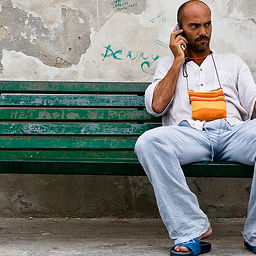

Target Captions:
a man in sandals and white cardigan sits on a green bench while talking on his cellphone
a man with blue pants and a white shirt sitting on a bench talking on a cellphone
a bald man in flip-flops sits on a green bench and talks on a cellphone
a man sitting on a green bench talking on the telephone
a man on a green bench is talking on his cellphone

Predicted Captions:
<start> calvin stacks horse-drawn bluff mats inflate jogs package displaying roaming quintet trooper possess rained possess interesting arena knights being swamp
<start> calvin stacks horse-drawn bluff mats inflate jogs package displaying roaming quintet trooper possess rained possess graveyard kiddie hooded twins motorcyclist
<start> calvin stacks horse-drawn bluff mats inflate jogs package displaying roaming quintet trooper possess rained possess interesting arena knights being llama


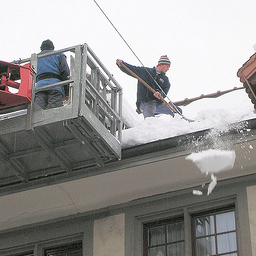

Target Captions:
a man shovels snow off of a roof while another stands in the contraption that allowed them to reach the high place
two men cleaning snow from a roof one 's in a <unk> while the other is <unk> on the roof
a man shoveling snow off the roof of a building
two people working on removing snow from a roof
two men work to shovel snow from <unk>

Predicted Captions:
<start> filtering moored graduate dozens ships outing shaking wizard blazing grassland grassland bags skater leotard moored fairy bridge bridge treeline moored
<start> filtering moored graduate dozens ships outing shaking wizard blazing grassland grassland bags skater leotard moored fairy bridge kites hooping attempts
<start> filtering moored graduate dozens ships outing shaking wizard blazing grassland grassland bags skater leotard moored fairy bridge kites atop logs


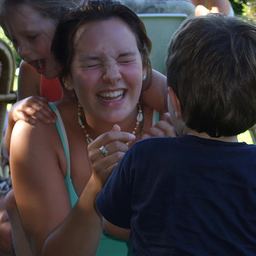

Target Captions:
a woman is laughing as two small boys play around her and a small girl climbs up her back
a girl laughs while holding an younger girl on her back and facing a small child
a woman in a green tank top is surrounded by three children laughing
a young woman playing with children at a backyard party in the summer
a woman playing with kids

Predicted Captions:
<start> transparent wife-beater possess separates parachutist atm hills those registers bluff neuroscience creation decked displays roaming treasure c holy oatmeal possess
<start> transparent wife-beater possess separates parachutist atm hills those registers bluff neuroscience creation decked displays roaming treasure c holy mats thumbs
<start> transparent wife-beater possess separates parachutist atm hills those registers bluff neuroscience creation decked displays roaming treasure c holy journey racks


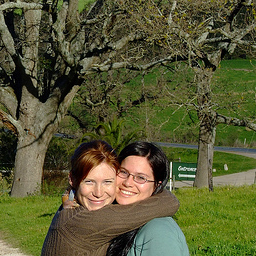

Target Captions:
two women hugging in a grassy fenced field with a cow 's behind in the background
two women are hugging on a path through a grassy area with a cow visible past them
two sisters hugging while visiting a farm and looking into the camera
two girls are hugging in front of a tree and a hill
two people hugging with cow in background at farm

Predicted Captions:
<start> poking atop tucking browses inside atop gras flip-flops wizard atop coated seagull twins atop gras atop atop bluff flippers atop
<start> poking atop tucking browses inside atop gras flip-flops wizard atop coated seagull twins atop gras stationed gras canyon ask browses
<start> poking atop tucking browses inside atop gras flip-flops wizard atop coated seagull twins atop gras atop atop shores bluff exhibition


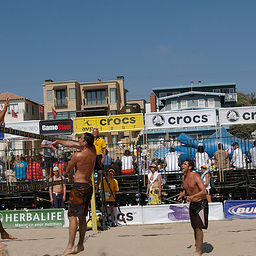

Target Captions:
a male volleyball player in red trunks tries to block the shot of the opposing player during a professional volleyball game
men playing volleyball with one player missing the ball but hands still in the air
a group of spectators watch a men 's sand volleyball game
volleyball players compete on a sunny day at the beach
men playing volleyball in the sand

Predicted Captions:
<start> barricades midday loaded mosaic we decide promenade snowbank inflate loaded moment hooded coated phrase lunchbox stunning stop statue observer moment
<start> barricades midday loaded mosaic we decide promenade snowbank inflate loaded moment hooded coated phrase lunchbox stunning stop statue observer bends
<start> barricades midday loaded mosaic we decide promenade snowbank inflate loaded moment hooded coated phrase lunchbox stunning stop statue moment hooded


In [6]:
## NOTE: generated captions here will be terrible as I used a non-trained model
beams = decoder.beam_sample(features, imgs=images, targets = captions, beam_size=3)
print_beam_outputs(beams, vocab, num_to_print=5)

In [ ]:
beams = decoder.beam_sample(features, imgs=images, targets = captions, beam_size=1) # beam_size = 1 (greedy)
print_beam_outputs(beams, vocab, num_to_print=5)